## Trajectory Partial Scanning
Now that we have a set of trajectories we will plant a region of interest containing roughly 10% of the trajectories where 20% will be from the blue set and 80% from the red set and then attempt to find that region or another region that is more anomalous.

In [2]:
import pyscan
import matplotlib.pyplot as plt
import random
import math
import statistics
import csv
import itertools
import numpy as np

def plot_points(ax, pts, c):
    xs = []
    ys = []
    for pt in pts:
        xs.append(pt[0] )
        ys.append(pt[1])
    ax.scatter(xs, ys, color=c)

def plot_points_traj(ax, pts, c):
    xs = []
    ys = []
    for pt in pts:
        xs.append(pt[0])
        ys.append(pt[1])
    ax.plot(xs, ys, color=c)
    
def plot_approx(ax, traj_pts, core_set_pts):
    ax.set_xlim([-.01, 1.01])
    ax.set_ylim([-.01, 1.01])
    plot_points_traj(ax, traj_pts, "g")
    plot_points(ax, core_set_pts, "b")
    ax.set_axis_off()
    
def plot_full_trajectories(red, blue, ax):
    plot_set = [(reg, True) for reg in blue] + [(reg, False) for reg in red]
    random.shuffle(plot_set)
    
    for traj, is_blue in plot_set:
        if is_blue:
            plot_points_traj(ax, traj, "b")
        else:
            plot_points_traj(ax, traj, "r")   
    

def remove_long_trajectories(trajectories, percent=.9):
    def toTraj(pts):
        return pyscan.Trajectory([pyscan.Point(p[0], p[1], 1.0) for p in pts])
    
    ltraj = sorted(toTraj(traj).get_length() for traj in trajectories)
    perc_len_traj = ltraj[int(percent * len(trajectories))]
    del ltraj
    return [traj for traj in trajectories if toTraj(traj).get_length() <= perc_len_traj]


def normalize(pt, mxx, mnx, mxy, mny):
    return (pt[0] - mnx) / (mxx - mnx), (pt[1] - mny) / (mxy - mny)


def read_csv(fname, filter_long=True):
    traj_id_set = []
    with open(fname) as f:
        curr_id = None
        mnx = float("inf")
        mxx = -float("inf")
        mny = float("inf")
        mxy = -float("inf")

        for row in csv.reader(f, delimiter=" "):
            try:
                if row[0] != curr_id:
                    curr_id = row[0]
                    traj_id_set.append([])
                if math.isnan(float(row[1])) or math.isinf(float(row[1])):
                    continue
                if math.isnan(float(row[2])) or math.isinf(float(row[2])):
                    continue

                x, y = (float(row[1]), float(row[2]))
                mnx = min(mnx, x)
                mny = min(mny, y)
                mxx = max(mxx, x)
                mxy = max(mxy, y)
                traj_id_set[-1].append((float(row[1]), float(row[2])))

            except ValueError:
                continue
        norm_traces = []
        while traj_id_set:
            norm_trace = []
            trace = traj_id_set.pop()
            for pt in trace:
                norm_trace.append(normalize(pt, mxx, mnx, mxy, mny))
            norm_traces.append(norm_trace)
        if filter_long:
            return remove_long_trajectories(norm_traces)
        else:
            return norm_traces
        
# Ok we finally have the trajectories scaled to be in a [0,1]x[0,1] box with the extremely 
#long trajectories removed
trajectories = read_csv("./bjtaxi_samples_10k.tsv")

### Halfplane Partial Scanning

Planted Region: HalfSpace(pyscan::Point<2>(-1.23057, -0.182595, 0.279671))
Found Region: HalfSpace(pyscan::Point<2>(-0.959084, -0.283122, 0.526223))


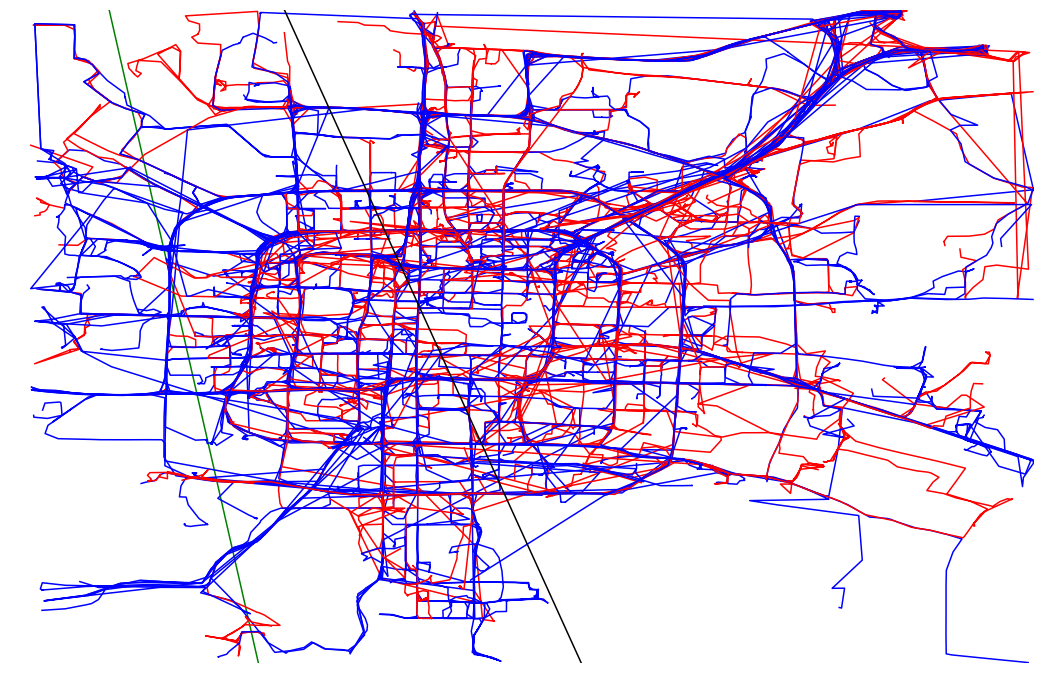

In [20]:
#Just set some parameter for finding the region.
n = 800
s = 20000
r = .05
p = .5
q = .2
eps_r = .001

#Plant a region
trajec_set = [[pyscan.Point(p[0], p[1], 1.0) for p in traj] for traj in trajectories]
red, blue, mx_plane, d = pyscan.plant_partial_halfplane(trajec_set, r, p, q, eps_r, pyscan.DISC)
m_sample = pyscan.uniform_sample(red, s, False)
b_sample = pyscan.uniform_sample(blue, s, False)
net_set1 = pyscan.my_sample(m_sample, n)
net_set2 = pyscan.my_sample(b_sample, n)
net_set = net_set1 + net_set2

m_sample = pyscan.to_weighted(m_sample)
b_sample = pyscan.to_weighted(b_sample)

reg, mx = pyscan.max_halfplane(net_set, m_sample, b_sample, pyscan.DISC)
    
print("Planted Region: " + str(mx_plane))
print("Found Region: " + str(reg))

_, ax = plt.subplots(figsize=(18, 12))
#Now lets plot what we got.
xs = np.arange(0, 1, .01)
ys = (-1 - mx_plane.get_coords()[0] * xs) * 1 / mx_plane.get_coords()[1]
ax.plot(xs, ys, color="g")

ys = (-1 - reg.get_coords()[0] * xs) * 1 / reg.get_coords()[1]
plot_full_trajectories([traj.get_pts() for traj in pyscan.my_sample(red, 100)], 
                       [traj.get_pts() for traj in pyscan.my_sample(blue, 100)], ax)

ax.plot(xs, ys, color="k")
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
plt.axis('off')
plt.show()

Unlike with point based models our planting code is much less likely to plant the actual maximum region and so usually the scanning algorithms find better regions, but the found region usually overlaps the planted region.

### Disk Partial Scanning

Planted Region: Disk(pyscan::Point<2>(0.334905, 0.400674, 1), 0.0825591)
Found Region: Disk(pyscan::Point<2>(0.388503, 0.44225, 1), 0.0998047)


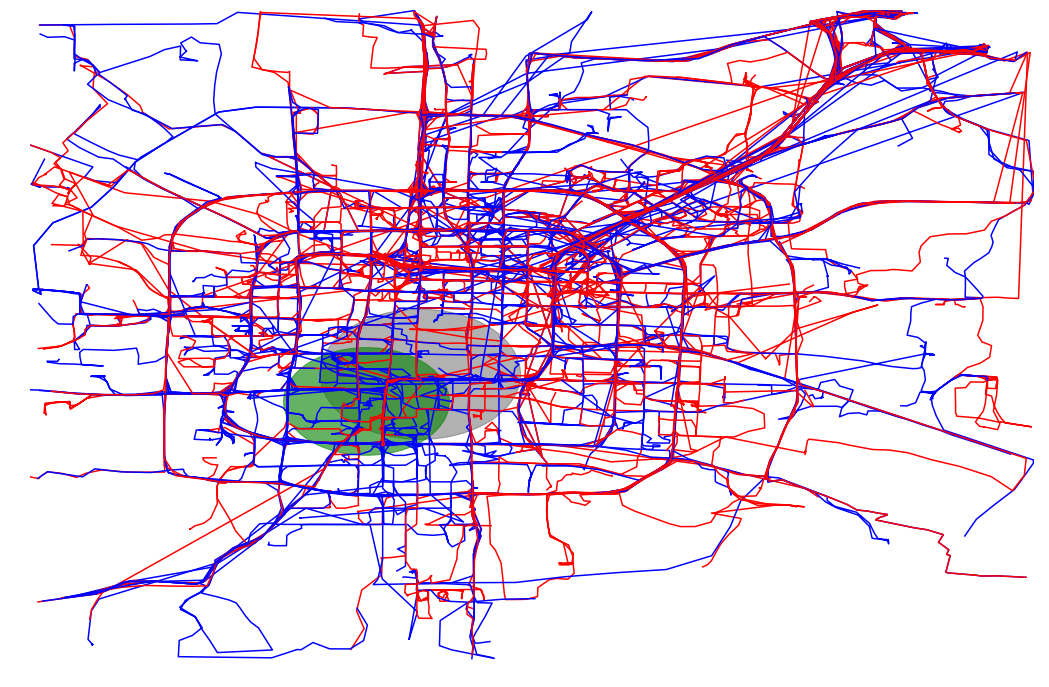

In [21]:
n = 100
s = 4000

r = .05
p = .5
q = .2
eps_r = .001
#Plant a region
trajec_set = [[pyscan.Point(p[0], p[1], 1.0) for p in traj] for traj in trajectories]

red, blue, planted_reg, d = pyscan.plant_partial_disk(trajec_set, r, p, q, eps_r, pyscan.DISC)
m_sample = pyscan.uniform_sample(red, s, False)
b_sample = pyscan.uniform_sample(blue, s, False)
net_set1 = pyscan.my_sample(m_sample, n)
net_set2 = pyscan.my_sample(b_sample, n)
net_set = net_set1 + net_set2

m_sample = pyscan.to_weighted(m_sample)
b_sample = pyscan.to_weighted(b_sample)


reg, mx = pyscan.max_disk_scale(net_set, m_sample, b_sample, .05, pyscan.DISC)


_, ax = plt.subplots(figsize=(1, 12))
#Now lets plot what we got.

print("Planted Region: " + str(planted_reg))
print("Found Region: " + str(reg))
actor = plt.Circle((reg.get_origin()[0], reg.get_origin()[1]), reg.get_radius(), alpha=.3, color="k")
ax.add_artist(actor)
actor = plt.Circle((planted_reg.get_origin()[0], planted_reg.get_origin()[1]), planted_reg.get_radius(), 
                   alpha=.6, color="g")
ax.add_artist(actor)


plot_full_trajectories([traj.get_pts() for traj in pyscan.my_sample(red, 100)], 
                       [traj.get_pts() for traj in pyscan.my_sample(blue, 100)], ax)

plt.axis('off')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
plt.show()